## LAB 5

**Imports & setup**


In [262]:
!pip install torch torchaudio mirdata scikit-learn tqdm matplotlib codecarbon librosa soundfile

In [263]:

import os
import platform
import time
import random
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio

import pandas as pd
import zipfile
import librosa

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from torchaudio.transforms import MelSpectrogram, Resample
from torch.utils.data import Dataset, DataLoader
import mirdata
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from codecarbon import EmissionsTracker



In [264]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

**Device detection**

CPU, CUDA or MPS


In [265]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='mps')

**Library load**

In [266]:
'''
magnatagatune = mirdata.initialize("tinysol")
magnatagatune.download()
all_ids = np.array(magnatagatune.track_ids)
len(all_ids)
'''

'\nmagnatagatune = mirdata.initialize("tinysol")\nmagnatagatune.download()\nall_ids = np.array(magnatagatune.track_ids)\nlen(all_ids)\n'

Manually using magnatagtune as initializing it didn't work.

In [289]:

if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/drive")
    search_roots = [
        Path("/content/drive/MyDrive/datalab5"),
        Path("/content/drive/MyDrive"),
        Path("/content")
    ]
else:
    search_roots = [
        Path.cwd(),
        Path.cwd().parent,
        Path.cwd().parent.parent
    ]

data_path = None
for root in search_roots:
    if root.exists():
        for p in root.rglob("annotations_final.csv"):
            data_path = p.parent
            break
    if data_path is not None:
        break

if data_path is None:
    raise FileNotFoundError("No se encontró 'annotations_final.csv' en rutas conocidas")

print("USING DATA DIR:", data_path)

data_dir = str(data_path)

ann_path = os.path.join(data_dir, "annotations_final.csv")
info_path = os.path.join(data_dir, "clip_info_final.csv")

df_ann = pd.read_csv(ann_path, sep="\t")
df_info = pd.read_csv(info_path, sep="\t")

audio_root = os.path.join(data_dir, "audio")
os.makedirs(audio_root, exist_ok=True)

full_zip = os.path.join(data_dir, "mp3_full.zip")
if not os.path.exists(os.path.join(audio_root, "000")):
    with zipfile.ZipFile(full_zip, "r") as z:
        z.extractall(audio_root)

tag_cols = [c for c in df_ann.columns if c != "clip_id"]

df_tags = (
    df_ann[tag_cols]
    .apply(pd.to_numeric, errors="coerce")
    .fillna(0)
    .astype(int)
)

Y_all = df_tags.values
tag_counts = Y_all.sum(axis=0).astype(int)

top_k = 50
top_indices = np.argsort(tag_counts)[::-1][:top_k]

Y_all_top = Y_all[:, top_indices]
classes_top = np.array(tag_cols)[top_indices]

all_ids = df_ann["clip_id"].values

max_tracks = 10000
if len(all_ids) > max_tracks:
    all_ids = all_ids[:max_tracks]
    Y_all_top = Y_all_top[:max_tracks]

path_map = dict(zip(df_info["clip_id"], df_info["mp3_path"]))

len(all_ids), Y_all_top.shape, len(classes_top)

USING DATA DIR: /Users/meco/Library/CloudStorage/OneDrive-Personal/Educación/UPF/Cursos/Machine Learning for Music/Labs/lab05/datalab5


(10000, (10000, 50), 50)

**Partition for train, validation and testing**

In [268]:
train_ids, temp_ids, Y_train, Y_temp = train_test_split(
    all_ids, Y_all_top, test_size=0.3, random_state=42
)

val_ids, test_ids, Y_val, Y_test = train_test_split(
    temp_ids, Y_temp, test_size=0.5, random_state=42
)

len(train_ids), len(val_ids), len(test_ids)

(7000, 1500, 1500)

**Dataset and data loaders**

In [269]:
class MagnaTagATuneDataset(Dataset):
    def __init__(self, ids, y_matrix, path_map, audio_root, sr_target=16000, duration=3.0):
        self.ids = list(ids)
        self.y_matrix = y_matrix
        self.path_map = path_map
        self.audio_root = audio_root
        self.sr_target = sr_target
        self.duration = duration
        self.n_samples = int(self.sr_target * self.duration)
        self.resample = Resample(orig_freq=44100, new_freq=self.sr_target)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        tid = int(self.ids[idx])
        rel_path = str(self.path_map[tid]).lstrip("./")
        audio_path = os.path.join(self.audio_root, rel_path)

        try:
            audio_np, sr = librosa.load(audio_path, sr=None, mono=False)
        except Exception:
            waveform = torch.zeros(self.n_samples)
            sr = self.sr_target
        else:
            waveform = torch.tensor(audio_np).float()
            if waveform.ndim > 1:
                waveform = waveform.mean(dim=0)

            if sr != self.sr_target:
                waveform = self.resample(waveform.unsqueeze(0)).squeeze(0)

            if waveform.shape[0] >= self.n_samples:
                waveform = waveform[: self.n_samples]
            else:
                pad = self.n_samples - waveform.shape[0]
                waveform = torch.cat([waveform, torch.zeros(pad)])

        y = torch.tensor(self.y_matrix[idx]).float()
        return {"audio": waveform, "labels": y}

train_dataset = MagnaTagATuneDataset(train_ids, Y_train, path_map, audio_root, sr_target=16000, duration=3.0)
val_dataset = MagnaTagATuneDataset(val_ids, Y_val, path_map, audio_root, sr_target=16000, duration=3.0)
test_dataset = MagnaTagATuneDataset(test_ids, Y_test, path_map, audio_root, sr_target=16000, duration=3.0)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

**Extract characteristics**

Specifically for the melspectrograms 

In [270]:
class FeatureExtractor(nn.Module):
    def __init__(self, sample_rate=16000, n_fft=1024, n_mels=64):
        super().__init__()
        self.melspectrogram = MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            n_mels=n_mels
        )

    def forward(self, x):
        x = self.melspectrogram(x)
        x = torch.log10(1 + 1000 * x)
        return x

In [271]:
feature_extractor = FeatureExtractor(sample_rate=16000, n_fft=1024, n_mels=64).to(device)

**Dimensions calculation for the CNN**

In [272]:
example_batch = next(iter(train_loader))
example_audio = example_batch["audio"][:1].to(device)
with torch.no_grad():
    example_mel = feature_extractor(example_audio)
example_mel.shape

torch.Size([1, 64, 94])

In [273]:
_, n_mels, time_steps = example_mel.shape
n_mels, time_steps

(64, 94)

In [274]:
pooled_mels = n_mels // 8
pooled_time = time_steps // 8
cnn_flat_dim = 128 * pooled_mels * pooled_time
cnn_flat_dim

11264

**Models MLP and CNN definition**

In [275]:
n_tags = Y_all_top.shape[1]

class MLPTagger(nn.Module):
    def __init__(self, n_mels=64, hidden=128, n_tags=50):
        super().__init__()
        self.fc1 = nn.Linear(n_mels, hidden)
        self.fc2 = nn.Linear(hidden, n_tags)

    def forward(self, x_mel):
        x = x_mel.mean(dim=-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [276]:
class CNNTagger(nn.Module):
    def __init__(self, n_tags=50, flat_dim=1024):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d((2, 2))
        self.fc1 = nn.Linear(flat_dim, 256)
        self.fc2 = nn.Linear(256, n_tags)

    def forward(self, x_mel):
        x = x_mel.unsqueeze(1)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [277]:
mlp_model = MLPTagger(n_mels=n_mels, hidden=128, n_tags=n_tags).to(device)
cnn_model = CNNTagger(n_tags=n_tags, flat_dim=cnn_flat_dim).to(device)

**Metric functions and loops for the training** 

In [278]:
criterion = nn.BCEWithLogitsLoss()

In [279]:
def compute_roc_auc(y_true, y_pred):
    try:
        return roc_auc_score(y_true, y_pred, average="macro")
    except ValueError:
        return np.nan

In [280]:
def train_one_epoch(model, loader, optimizer, feature_extractor, device):
    model.train()
    running_loss = 0.0
    all_true = []
    all_pred = []
    pbar = tqdm(loader, desc="Train", leave=False)
    for batch in pbar:
        audio = batch["audio"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            mel = feature_extractor(audio)
        outputs = model(mel)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * audio.size(0)
        probs = torch.sigmoid(outputs).detach().cpu().numpy()
        all_pred.append(probs)
        all_true.append(labels.cpu().numpy())
    epoch_loss = running_loss / len(loader.dataset)
    all_true = np.vstack(all_true)
    all_pred = np.vstack(all_pred)
    auc = compute_roc_auc(all_true, all_pred)
    return epoch_loss, auc

In [281]:
def evaluate(model, loader, feature_extractor, device):
    model.eval()
    running_loss = 0.0
    all_true = []
    all_pred = []
    with torch.no_grad():
        pbar = tqdm(loader, desc="Eval", leave=False)
        for batch in pbar:
            audio = batch["audio"].to(device)
            labels = batch["labels"].to(device)
            mel = feature_extractor(audio)
            outputs = model(mel)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * audio.size(0)
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_pred.append(probs)
            all_true.append(labels.cpu().numpy())
    epoch_loss = running_loss / len(loader.dataset)
    all_true = np.vstack(all_true)
    all_pred = np.vstack(all_pred)
    auc = compute_roc_auc(all_true, all_pred)
    return epoch_loss, auc

In [282]:
def train_model(model, train_loader, val_loader, feature_extractor, device, n_epochs=5, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {"train_loss": [], "val_loss": [], "val_auc": []}
    for epoch in range(n_epochs):
        start_time = time.time()
        train_loss, train_auc = train_one_epoch(model, train_loader, optimizer, feature_extractor, device)
        val_loss, val_auc = evaluate(model, val_loader, feature_extractor, device)
        elapsed = time.time() - start_time
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_auc"].append(val_auc)
        print(
            f"Epoch {epoch+1}/{n_epochs} | "
            f"Train loss: {train_loss:.4f} | "
            f"Val loss: {val_loss:.4f} | "
            f"Val ROC-AUC: {val_auc:.4f} | "
            f"Time: {elapsed:.1f}s"
        )
    return history

**Training with environmental impact measurements (with CodeCarbon)**

We will use 10 epochs to get a high accuracy

In [283]:
epochs_list = [5, 10, 15]
multi_results = []
histories_mlp = {}
histories_cnn = {}

for n_ep in epochs_list:
    print(f"\n===== TRAINING WITH {n_ep} EPOCHS =====")

    set_seed(42)

    mlp_tmp = MLPTagger(n_mels=n_mels, hidden=128, n_tags=n_tags).to(device)
    cnn_tmp = CNNTagger(n_tags=n_tags, flat_dim=cnn_flat_dim).to(device)

    tracker_tmp = EmissionsTracker(measure_power_secs=10, log_level="error", save_to_file=False)
    tracker_tmp.start()
    t0 = time.time()

    print(f"\n--- MLP ({n_ep} epochs) ---")
    history_mlp_tmp = train_model(
        mlp_tmp,
        train_loader,
        val_loader,
        feature_extractor,
        device,
        n_epochs=n_ep,
        lr=1e-3
    )

    print(f"\n--- CNN ({n_ep} epochs) ---")
    history_cnn_tmp = train_model(
        cnn_tmp,
        train_loader,
        val_loader,
        feature_extractor,
        device,
        n_epochs=n_ep,
        lr=1e-3
    )

    elapsed = time.time() - t0
    emissions_tmp = tracker_tmp.stop()

    test_loss_mlp_tmp, test_auc_mlp_tmp = evaluate(mlp_tmp, test_loader, feature_extractor, device)
    test_loss_cnn_tmp, test_auc_cnn_tmp = evaluate(cnn_tmp, test_loader, feature_extractor, device)

    best_val_mlp = float(np.nanmax(history_mlp_tmp["val_auc"]))
    best_val_cnn = float(np.nanmax(history_cnn_tmp["val_auc"]))

    multi_results.append(
        {
            "epochs": n_ep,
            "mlp_best_val_auc": best_val_mlp,
            "cnn_best_val_auc": best_val_cnn,
            "mlp_test_auc": test_auc_mlp_tmp,
            "cnn_test_auc": test_auc_cnn_tmp,
            "total_train_time_s": elapsed,
            "emissions_kg": emissions_tmp,
        }
    )

    histories_mlp[n_ep] = history_mlp_tmp
    histories_cnn[n_ep] = history_cnn_tmp

results_df = pd.DataFrame(multi_results)
print("\n===== EPOCHS COMPARISON SUMMARY =====")
print(results_df)


===== TRAINING WITH 5 EPOCHS =====

--- MLP (5 epochs) ---


Epoch 1/5 | Train loss: 0.2184 | Val loss: 0.1876 | Val ROC-AUC: 0.6597 | Time: 51.9s


Epoch 2/5 | Train loss: 0.1843 | Val loss: 0.1786 | Val ROC-AUC: 0.6989 | Time: 46.7s


Epoch 3/5 | Train loss: 0.1758 | Val loss: 0.1706 | Val ROC-AUC: 0.7342 | Time: 51.5s


Epoch 4/5 | Train loss: 0.1722 | Val loss: 0.1673 | Val ROC-AUC: 0.7520 | Time: 41.9s


Epoch 5/5 | Train loss: 0.1693 | Val loss: 0.1683 | Val ROC-AUC: 0.7549 | Time: 44.0s

--- CNN (5 epochs) ---


Epoch 1/5 | Train loss: 0.1894 | Val loss: 0.1636 | Val ROC-AUC: 0.7774 | Time: 51.9s


Epoch 2/5 | Train loss: 0.1640 | Val loss: 0.1596 | Val ROC-AUC: 0.8045 | Time: 56.7s


Epoch 3/5 | Train loss: 0.1542 | Val loss: 0.1512 | Val ROC-AUC: 0.8284 | Time: 55.7s


Epoch 4/5 | Train loss: 0.1458 | Val loss: 0.1510 | Val ROC-AUC: 0.8340 | Time: 57.1s


Epoch 5/5 | Train loss: 0.1394 | Val loss: 0.1534 | Val ROC-AUC: 0.8338 | Time: 55.4s



===== TRAINING WITH 10 EPOCHS =====

--- MLP (10 epochs) ---


Epoch 1/10 | Train loss: 0.2184 | Val loss: 0.1876 | Val ROC-AUC: 0.6597 | Time: 48.8s


Epoch 2/10 | Train loss: 0.1843 | Val loss: 0.1786 | Val ROC-AUC: 0.6989 | Time: 47.2s


Epoch 3/10 | Train loss: 0.1758 | Val loss: 0.1706 | Val ROC-AUC: 0.7342 | Time: 47.1s


Epoch 4/10 | Train loss: 0.1722 | Val loss: 0.1673 | Val ROC-AUC: 0.7520 | Time: 47.5s


Epoch 5/10 | Train loss: 0.1693 | Val loss: 0.1683 | Val ROC-AUC: 0.7549 | Time: 47.0s


Epoch 6/10 | Train loss: 0.1672 | Val loss: 0.1639 | Val ROC-AUC: 0.7729 | Time: 45.9s


Epoch 7/10 | Train loss: 0.1657 | Val loss: 0.1644 | Val ROC-AUC: 0.7768 | Time: 47.5s


Epoch 8/10 | Train loss: 0.1644 | Val loss: 0.1633 | Val ROC-AUC: 0.7827 | Time: 50.4s


Epoch 9/10 | Train loss: 0.1629 | Val loss: 0.1615 | Val ROC-AUC: 0.7905 | Time: 46.8s


Epoch 10/10 | Train loss: 0.1621 | Val loss: 0.1604 | Val ROC-AUC: 0.7948 | Time: 47.9s

--- CNN (10 epochs) ---


Epoch 1/10 | Train loss: 0.1902 | Val loss: 0.1658 | Val ROC-AUC: 0.7806 | Time: 56.6s


Epoch 2/10 | Train loss: 0.1632 | Val loss: 0.1639 | Val ROC-AUC: 0.8089 | Time: 56.6s


Epoch 3/10 | Train loss: 0.1519 | Val loss: 0.1496 | Val ROC-AUC: 0.8377 | Time: 56.4s


Epoch 4/10 | Train loss: 0.1438 | Val loss: 0.1564 | Val ROC-AUC: 0.8393 | Time: 55.0s


Epoch 5/10 | Train loss: 0.1367 | Val loss: 0.1515 | Val ROC-AUC: 0.8432 | Time: 54.8s


Epoch 6/10 | Train loss: 0.1296 | Val loss: 0.1471 | Val ROC-AUC: 0.8522 | Time: 56.1s


Epoch 7/10 | Train loss: 0.1215 | Val loss: 0.1515 | Val ROC-AUC: 0.8426 | Time: 55.4s


Epoch 8/10 | Train loss: 0.1125 | Val loss: 0.1525 | Val ROC-AUC: 0.8447 | Time: 55.4s


Epoch 9/10 | Train loss: 0.1025 | Val loss: 0.1594 | Val ROC-AUC: 0.8312 | Time: 55.9s


Epoch 10/10 | Train loss: 0.0912 | Val loss: 0.1674 | Val ROC-AUC: 0.8332 | Time: 55.5s



===== TRAINING WITH 15 EPOCHS =====

--- MLP (15 epochs) ---


Epoch 1/15 | Train loss: 0.2184 | Val loss: 0.1876 | Val ROC-AUC: 0.6597 | Time: 48.9s


Epoch 2/15 | Train loss: 0.1843 | Val loss: 0.1786 | Val ROC-AUC: 0.6989 | Time: 46.2s


Epoch 3/15 | Train loss: 0.1758 | Val loss: 0.1706 | Val ROC-AUC: 0.7342 | Time: 45.3s


Epoch 4/15 | Train loss: 0.1722 | Val loss: 0.1673 | Val ROC-AUC: 0.7520 | Time: 46.6s


Epoch 5/15 | Train loss: 0.1693 | Val loss: 0.1683 | Val ROC-AUC: 0.7549 | Time: 46.8s


Epoch 6/15 | Train loss: 0.1672 | Val loss: 0.1639 | Val ROC-AUC: 0.7729 | Time: 46.9s


Epoch 7/15 | Train loss: 0.1657 | Val loss: 0.1644 | Val ROC-AUC: 0.7768 | Time: 53.3s


Epoch 8/15 | Train loss: 0.1644 | Val loss: 0.1633 | Val ROC-AUC: 0.7827 | Time: 47.9s


Epoch 9/15 | Train loss: 0.1629 | Val loss: 0.1615 | Val ROC-AUC: 0.7905 | Time: 48.0s


Epoch 10/15 | Train loss: 0.1621 | Val loss: 0.1604 | Val ROC-AUC: 0.7948 | Time: 48.0s


Epoch 11/15 | Train loss: 0.1619 | Val loss: 0.1625 | Val ROC-AUC: 0.7962 | Time: 47.1s


Epoch 12/15 | Train loss: 0.1613 | Val loss: 0.1595 | Val ROC-AUC: 0.7989 | Time: 48.1s


Epoch 13/15 | Train loss: 0.1600 | Val loss: 0.1589 | Val ROC-AUC: 0.8017 | Time: 50.1s


Epoch 14/15 | Train loss: 0.1595 | Val loss: 0.1580 | Val ROC-AUC: 0.8018 | Time: 47.6s


Epoch 15/15 | Train loss: 0.1589 | Val loss: 0.1588 | Val ROC-AUC: 0.7958 | Time: 47.2s

--- CNN (15 epochs) ---


Epoch 1/15 | Train loss: 0.1887 | Val loss: 0.1736 | Val ROC-AUC: 0.7726 | Time: 58.9s


Epoch 2/15 | Train loss: 0.1624 | Val loss: 0.1565 | Val ROC-AUC: 0.8125 | Time: 55.4s


Epoch 3/15 | Train loss: 0.1527 | Val loss: 0.1510 | Val ROC-AUC: 0.8325 | Time: 57.4s


Epoch 4/15 | Train loss: 0.1453 | Val loss: 0.1577 | Val ROC-AUC: 0.8252 | Time: 54.9s


Epoch 5/15 | Train loss: 0.1391 | Val loss: 0.1496 | Val ROC-AUC: 0.8511 | Time: 58.5s


Epoch 6/15 | Train loss: 0.1322 | Val loss: 0.1449 | Val ROC-AUC: 0.8515 | Time: 56.8s


Epoch 7/15 | Train loss: 0.1247 | Val loss: 0.1500 | Val ROC-AUC: 0.8447 | Time: 55.4s


Epoch 8/15 | Train loss: 0.1176 | Val loss: 0.1517 | Val ROC-AUC: 0.8429 | Time: 57.2s


Epoch 9/15 | Train loss: 0.1086 | Val loss: 0.1566 | Val ROC-AUC: 0.8441 | Time: 56.1s


Epoch 10/15 | Train loss: 0.0990 | Val loss: 0.1579 | Val ROC-AUC: 0.8336 | Time: 61.3s


Epoch 11/15 | Train loss: 0.0884 | Val loss: 0.1760 | Val ROC-AUC: 0.8270 | Time: 54.7s


Epoch 12/15 | Train loss: 0.0770 | Val loss: 0.1805 | Val ROC-AUC: 0.8232 | Time: 58.5s


Epoch 13/15 | Train loss: 0.0663 | Val loss: 0.1971 | Val ROC-AUC: 0.8150 | Time: 58.2s


Epoch 14/15 | Train loss: 0.0555 | Val loss: 0.2144 | Val ROC-AUC: 0.8181 | Time: 61.5s


Epoch 15/15 | Train loss: 0.0460 | Val loss: 0.2334 | Val ROC-AUC: 0.8026 | Time: 57.1s



===== EPOCHS COMPARISON SUMMARY =====
   epochs  mlp_best_val_auc  cnn_best_val_auc  mlp_test_auc  cnn_test_auc  \
0       5          0.754899          0.834024      0.758736      0.827566   
1      10          0.794751          0.852179      0.794684      0.828658   
2      15          0.801786          0.851470      0.796189      0.809511   

   total_train_time_s  emissions_kg  
0          512.684685      0.000273  
1         1033.836350      0.000550  
2         1579.751626      0.000840  


**Evaluation in the test**

In [284]:
'''
test_loss_mlp, test_auc_mlp = evaluate(mlp_model, test_loader, feature_extractor, device)
test_loss_cnn, test_auc_cnn = evaluate(cnn_model, test_loader, feature_extractor, device)
print(f"MLP  | Test loss: {test_loss_mlp:.4f} | Test ROC-AUC: {test_auc_mlp:.4f}")
print(f"CNN  | Test loss: {test_loss_cnn:.4f} | Test ROC-AUC: {test_auc_cnn:.4f}")
'''

'\ntest_loss_mlp, test_auc_mlp = evaluate(mlp_model, test_loader, feature_extractor, device)\ntest_loss_cnn, test_auc_cnn = evaluate(cnn_model, test_loader, feature_extractor, device)\nprint(f"MLP  | Test loss: {test_loss_mlp:.4f} | Test ROC-AUC: {test_auc_mlp:.4f}")\nprint(f"CNN  | Test loss: {test_loss_cnn:.4f} | Test ROC-AUC: {test_auc_cnn:.4f}")\n'

**Learning curves**

In [285]:
history_mlp = histories_mlp[10]
history_cnn = histories_cnn[10]

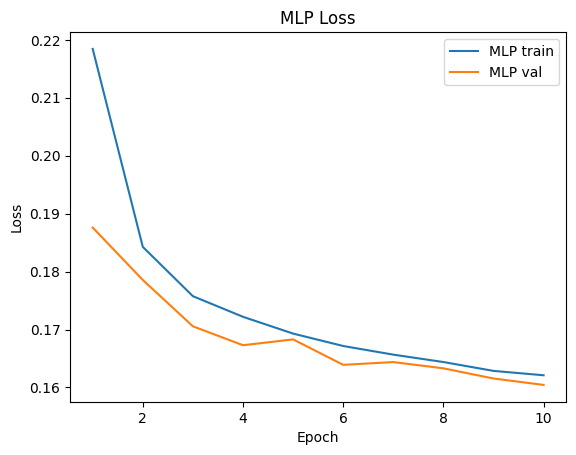

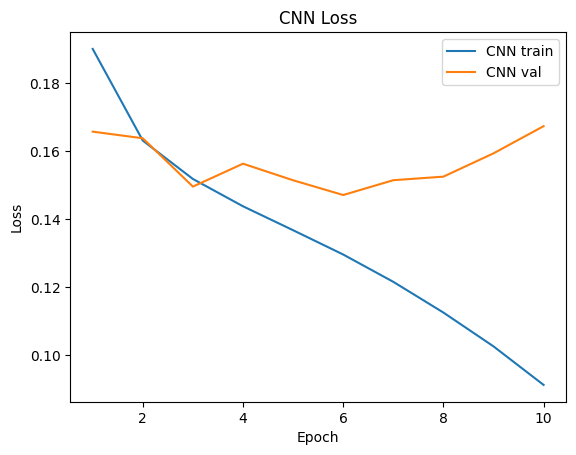

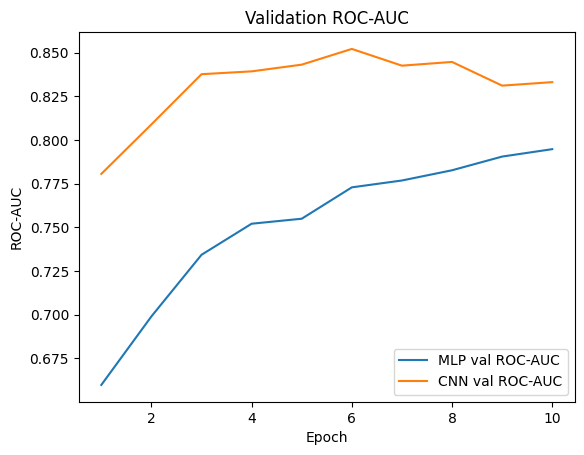

In [286]:
import matplotlib.pyplot as plt

epochs_mlp = range(1, len(history_mlp["train_loss"]) + 1)
epochs_cnn = range(1, len(history_cnn["train_loss"]) + 1)

plt.figure()
plt.plot(epochs_mlp, history_mlp["train_loss"], label="MLP train")
plt.plot(epochs_mlp, history_mlp["val_loss"], label="MLP val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_cnn, history_cnn["train_loss"], label="CNN train")
plt.plot(epochs_cnn, history_cnn["val_loss"], label="CNN val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_mlp, history_mlp["val_auc"], label="MLP val ROC-AUC")
plt.plot(epochs_cnn, history_cnn["val_auc"], label="CNN val ROC-AUC")
plt.xlabel("Epoch")
plt.ylabel("ROC-AUC")
plt.title("Validation ROC-AUC")
plt.legend()
plt.show()

## ALL RESULTS FOR ANALYSIS

In [287]:
row10 = results_df[results_df["epochs"] == 10].iloc[0]

mlp_params = sum(p.numel() for p in mlp_model.parameters() if p.requires_grad)
cnn_params = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)

mlp_best_val_auc = float(row10["mlp_best_val_auc"])
cnn_best_val_auc = float(row10["cnn_best_val_auc"])
test_auc_mlp = float(row10["mlp_test_auc"])
test_auc_cnn = float(row10["cnn_test_auc"])
total_time_10 = float(row10["total_train_time_s"])
emissions_kg_10 = float(row10["emissions_kg"])

print("===== EXPERIMENT SUMMARY (10 epochs) =====")
print(f"Device used: {device}")
print(f"Train/Val/Test sizes: {len(train_dataset)}/{len(val_dataset)}/{len(test_dataset)}")
print(f"Number of tags (output dim): {n_tags}")
print("")
print("Model sizes (trainable parameters)")
print(f"MLP params: {mlp_params}")
print(f"CNN params: {cnn_params}")
print("")
print("Validation performance (best across epochs)")
print(f"MLP best val ROC-AUC (10 ep): {mlp_best_val_auc:.4f}")
print(f"CNN best val ROC-AUC (10 ep): {cnn_best_val_auc:.4f}")
print("")
print("Test performance (10 ep models)")
print(f"MLP  | Test ROC-AUC: {test_auc_mlp:.4f}")
print(f"CNN  | Test ROC-AUC: {test_auc_cnn:.4f}")
print("")
print("Training time (approx., 10 ep total MLP+CNN)")
print(f"Total training time: {total_time_10:.1f} s")
print("")
print("Environmental impact (CodeCarbon, 10 ep total)")
print(f"Estimated CO2 emissions (MLP+CNN): {emissions_kg_10:.6f} kg CO2eq")

===== EXPERIMENT SUMMARY (10 epochs) =====
Device used: mps
Train/Val/Test sizes: 7000/1500/1500
Number of tags (output dim): 50

Model sizes (trainable parameters)
MLP params: 14770
CNN params: 2989810

Validation performance (best across epochs)
MLP best val ROC-AUC (10 ep): 0.7948
CNN best val ROC-AUC (10 ep): 0.8522

Test performance (10 ep models)
MLP  | Test ROC-AUC: 0.7947
CNN  | Test ROC-AUC: 0.8287

Training time (approx., 10 ep total MLP+CNN)
Total training time: 1033.8 s

Environmental impact (CodeCarbon, 10 ep total)
Estimated CO2 emissions (MLP+CNN): 0.000550 kg CO2eq


## EVALUATION WITH BIGGER DATASET BATCH FOR ANALYSIS

In [288]:
subset_fraction = 0.5
n_total = len(all_ids)
subset_n = int(n_total * subset_fraction)

rng = np.random.default_rng(123)
subset_idx = rng.choice(n_total, size=subset_n, replace=False)

subset_ids = all_ids[subset_idx]
subset_Y = Y_all_top[subset_idx]

train_ids_half, temp_ids_half, Y_train_half, Y_temp_half = train_test_split(
    subset_ids, subset_Y, test_size=0.3, random_state=42
)

val_ids_half, test_ids_half, Y_val_half, Y_test_half = train_test_split(
    temp_ids_half, Y_temp_half, test_size=0.5, random_state=42
)

train_dataset_half = MagnaTagATuneDataset(
    train_ids_half, Y_train_half, path_map, audio_root, sr_target=16000, duration=3.0
)
val_dataset_half = MagnaTagATuneDataset(
    val_ids_half, Y_val_half, path_map, audio_root, sr_target=16000, duration=3.0
)
test_dataset_half = MagnaTagATuneDataset(
    test_ids_half, Y_test_half, path_map, audio_root, sr_target=16000, duration=3.0
)

train_loader_half = DataLoader(train_dataset_half, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader_half = DataLoader(val_dataset_half, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader_half = DataLoader(test_dataset_half, batch_size=batch_size, shuffle=False, drop_last=False)

mlp_half = MLPTagger(n_mels=n_mels, hidden=128, n_tags=n_tags).to(device)
cnn_half = CNNTagger(n_tags=n_tags, flat_dim=cnn_flat_dim).to(device)

tracker_half = EmissionsTracker(measure_power_secs=10, log_level="error", save_to_file=False)
start_exp_half = time.time()
tracker_half.start()

print("Training MLP model (half dataset)")
history_mlp_half = train_model(
    mlp_half,
    train_loader_half,
    val_loader_half,
    feature_extractor,
    device,
    n_epochs=5,
    lr=1e-3
)

print("Training CNN model (half dataset)")
history_cnn_half = train_model(
    cnn_half,
    train_loader_half,
    val_loader_half,
    feature_extractor,
    device,
    n_epochs=5,
    lr=1e-3
)

emissions_half = tracker_half.stop()
total_time_half = time.time() - start_exp_half

test_loss_mlp_half, test_auc_mlp_half = evaluate(mlp_half, test_loader_half, feature_extractor, device)
test_loss_cnn_half, test_auc_cnn_half = evaluate(cnn_half, test_loader_half, feature_extractor, device)

print("\n===== HALF DATASET SUMMARY =====")
print(f"Subset clips used: {subset_n} de {n_total}")
print(f"Train/Val/Test sizes: {len(train_ids_half)}/{len(val_ids_half)}/{len(test_ids_half)}")
print(f"MLP  | Test loss: {test_loss_mlp_half:.4f} | Test ROC-AUC: {test_auc_mlp_half:.4f}")
print(f"CNN  | Test loss: {test_loss_cnn_half:.4f} | Test ROC-AUC: {test_auc_cnn_half:.4f}")
print(f"Total training time (half dataset): {total_time_half:.1f} s")
print(f"Estimated CO2 emissions (half dataset, MLP+CNN): {emissions_half:.6f} kg CO2eq")

Training MLP model (half dataset)


Epoch 1/5 | Train loss: 0.2474 | Val loss: 0.1969 | Val ROC-AUC: 0.6199 | Time: 24.9s


Epoch 2/5 | Train loss: 0.1934 | Val loss: 0.1875 | Val ROC-AUC: 0.6774 | Time: 26.2s


Epoch 3/5 | Train loss: 0.1856 | Val loss: 0.1835 | Val ROC-AUC: 0.6983 | Time: 26.0s


Epoch 4/5 | Train loss: 0.1811 | Val loss: 0.1791 | Val ROC-AUC: 0.7156 | Time: 27.1s


Epoch 5/5 | Train loss: 0.1778 | Val loss: 0.1757 | Val ROC-AUC: 0.7304 | Time: 26.5s
Training CNN model (half dataset)


Epoch 1/5 | Train loss: 0.2035 | Val loss: 0.1755 | Val ROC-AUC: 0.7596 | Time: 29.2s


Epoch 2/5 | Train loss: 0.1719 | Val loss: 0.1666 | Val ROC-AUC: 0.7839 | Time: 28.1s


Epoch 3/5 | Train loss: 0.1624 | Val loss: 0.1678 | Val ROC-AUC: 0.7886 | Time: 30.6s


Epoch 4/5 | Train loss: 0.1543 | Val loss: 0.1670 | Val ROC-AUC: 0.8143 | Time: 29.9s


Epoch 5/5 | Train loss: 0.1454 | Val loss: 0.1593 | Val ROC-AUC: 0.8176 | Time: 30.9s



===== HALF DATASET SUMMARY =====
Subset clips used: 5000 de 10000
Train/Val/Test sizes: 3500/750/750
MLP  | Test loss: 0.1742 | Test ROC-AUC: 0.7087
CNN  | Test loss: 0.1531 | Test ROC-AUC: 0.8284
Total training time (half dataset): 279.4 s
Estimated CO2 emissions (half dataset, MLP+CNN): 0.000149 kg CO2eq
